In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

from FRVRS import nu, fu
from pandas import DataFrame
import numpy as np
import pandas as pd
import re

In [3]:

# load data frames
data_frames_list = nu.load_data_frames(frvrs_logs_df='frvrs_logs_df', scene_stats_df='scene_stats_df')

Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/frvrs_logs_df.pkl.
Attempting to load /mnt/c/Users/DaveBabbitt/Documents/GitHub/itm-analysis-reporting/saves/pkl/scene_stats_df.pkl.



# Build a Model to Predict Measure of Right Ordering


## Create a data frame with all the feature columns

In [4]:

scene_stats_df = data_frames_list['scene_stats_df']
scene_stats_df.drop(columns=['is_cluster2'], inplace=True)
# print(sorted(scene_stats_df.columns))

In [5]:

# Ensure that you have no duplicate columns in the data frame
mask_series = scene_stats_df.columns.duplicated(keep='first')
if mask_series.any():
    print(scene_stats_df.shape)
    print(scene_stats_df.columns[mask_series].tolist())
    
    # Drop the duplicate columns using the mask
    scene_stats_df.drop(scene_stats_df.columns[mask_series], axis='columns', inplace=True)
    print(scene_stats_df.shape)

In [6]:

frvrs_logs_df = data_frames_list['frvrs_logs_df']
print(frvrs_logs_df.shape) # (829116, 125)

(829116, 125)


In [7]:

# Add the target variable values back into scene stats
target_variable = 'measure_of_right_ordering'
if (target_variable not in scene_stats_df.columns) and (target_variable in frvrs_logs_df.columns):
    for (session_uuid, scene_id, target_variable_value), _ in frvrs_logs_df.groupby(fu.scene_groupby_columns+[target_variable]):
        mask_series = True
        for cn in fu.scene_groupby_columns: mask_series &= (scene_stats_df[cn] == eval(cn))
        scene_stats_df.loc[mask_series, target_variable] = target_variable_value

In [8]:

# Remove columns to get the best input features
input_features = list(set(scene_stats_df.columns) - set([
    target_variable, 'session_uuid', 'adherence_to_salt', 'stills_value', 'walkers_value', 'actual_distracted_delta', 'measure_of_ideal_ordering',
    'actual_engagement_distance', 'actual_ideal_delta', 'measure_of_distracted_ordering', 'ideal_engagement_distance', 'distracted_engagement_distance'
]))

In [9]:

# Keep track of the target variable and input features columns
columns_list = [target_variable] + input_features
scene_history_df = scene_stats_df[columns_list].dropna(axis='columns', how='all').dropna(axis='index', how='any')
print(scene_history_df.shape) # (616, 39)

(551, 39)



## One-hot encode it

In [10]:

# Analyze the data frame for input features that need to be encoded
column_descriptions_df = nu.get_column_descriptions(scene_history_df.sample(min(2000, scene_history_df.shape[0])))
mask_series = (column_descriptions_df.dtype == 'object')
df = column_descriptions_df[mask_series]
display(df)
encodeable_columns = list(set(df.column_name) - set([target_variable]))

,column_name,dtype,count_blanks,count_uniques,count_zeroes,has_dates,min_value,max_value,only_integers
38,scene_type,object,0,2,0,False,Orientation,Triage,NaN


In [11]:

# One-hot encode the input features columns in the one-hot encoded data frame
ascii_regex = re.compile('[^a-z0-9]+')
one_hot_encode_df = nu.one_hot_encode(scene_history_df, encodeable_columns)
one_hot_encode_df = one_hot_encode_df.rename(columns={cn: ascii_regex.sub('_', cn.lower()).strip('_') for cn in one_hot_encode_df.columns})
columns_obj = one_hot_encode_df.columns
assert len(columns_obj) == len(set(columns_obj)), f"Duplicate column names: {columns_obj[columns_obj.duplicated()].tolist()}"
columns_list = [cn for cn in one_hot_encode_df.columns if any(map(lambda x: cn.endswith(x), ['_null', '_nan']))]
print(one_hot_encode_df.shape) # (31, 79)
print(columns_list)
# df = one_hot_encode_df.sample(min(12, one_hot_encode_df.shape[0])).dropna(axis='columns', how='all').T
# display(df.sample(min(20, df.shape[0])).sort_index())

(551, 41)
['scene_type_nan']



## Train a model on it

In [12]:

# Train a model on the scene history data frame
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
df = one_hot_encode_df.dropna(axis='index', how='any')
X_train, X_test, y_train, y_test = train_test_split(
    df.drop([target_variable], axis='columns'),
    df[target_variable],
    test_size=0.25,
    random_state=42
)

# Convert the uint8 features to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [13]:

# Create a decision tree regressor
dtr_model = DecisionTreeRegressor()
dtr_model.fit(X_train, y_train)

# Predict on the test set
y_pred = dtr_model.predict(X_test)

# Calculate Mean Squared Error (MSE)
dtr_mse = np.mean((y_pred - y_test)**2)

# Calculate the feature importances
feature_importances = dtr_model.feature_importances_

# Create a data frame to store feature names and importances
feature_importances_df = pd.DataFrame()
feature_importances_df['feature_name'] = df.drop(target_variable, axis='columns').columns
feature_importances_df['feature_importance'] = feature_importances

In [14]:

# Train a linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on the test set
y_pred = lr_model.predict(X_test)

# Calculate average squared error
lr_mse = np.mean((y_pred - y_test)**2)

# Get the coefficients of the linear regression model
feature_coefficients = lr_model.coef_[0]

# Create a data frame to store the feature names and feature coefficients
feature_coefficients_df = pd.DataFrame()
feature_coefficients_df['feature_name'] = df.drop(target_variable, axis='columns').columns
feature_coefficients_df['feature_coefficient'] = feature_coefficients
feature_coefficients_df['absolute_coefficient'] = feature_coefficients_df.feature_coefficient.map(lambda x: abs(x))


## Evaluate the accuracies and importances

In [15]:

# Print the accuracies
print('DTR MSE:', dtr_mse)
print('LR MSE:', lr_mse)

DTR MSE: 0.15381773355726747
LR MSE: 0.10981629944572563


In [16]:

# Display the feature importances data frame
df = feature_importances_df.sort_values('feature_importance', ascending=False).head(10)
dtr_importances_list = df.feature_name.tolist()
display(df)

,feature_name,feature_importance
1,patient_sort_complexity,0.359702
7,last_still_engagement,0.203993
36,injury_severity_turbulence,0.067493
8,first_engagement,0.050586
18,injury_treatments_count,0.043904
32,patient_sort_turbulence,0.041358
2,time_to_last_hemorrhage_controlled,0.039013
11,pulse_taken_count,0.028663
28,wave_command_count,0.026858
12,total_actions,0.023430


In [17]:

# Display the feature coefficients data frame
columns_list = ['feature_name', 'feature_coefficient']
df = feature_coefficients_df.sort_values('absolute_coefficient', ascending=False)[columns_list].head(10)
lr_importances_list = df.feature_name.tolist()
display(df)

,feature_name,feature_coefficient
0,injury_not_treated_count,-0.000231
1,patient_sort_complexity,-0.000231
22,patient_count,-0.000231
23,last_engagement,-0.000231
24,scene_start,-0.000231
25,percent_hemorrhage_controlled,-0.000231
26,teleport_count,-0.000231
27,is_scene_aborted,-0.000231
28,wave_command_count,-0.000231
29,first_treatment,-0.000231


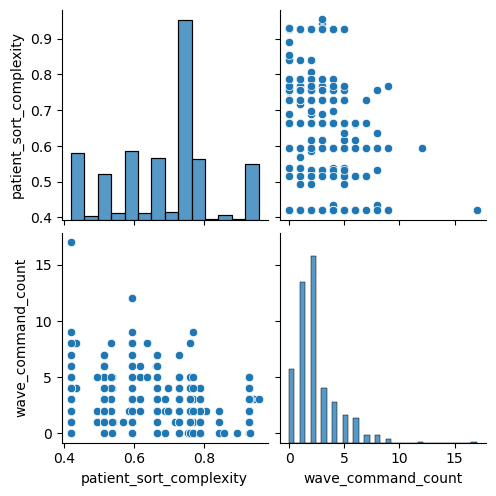

In [18]:

# Get the feature names common to both data frames
import seaborn as sns

importances_list = list(set(dtr_importances_list).intersection(set(lr_importances_list)))
PairGrid_obj = sns.pairplot(scene_history_df[importances_list])